In [3]:
import os
import torch
import tqdm
import math
import gpytorch
from torch.nn import Linear
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution, \
    LMCVariationalStrategy
from gpytorch.distributions import MultivariateNormal
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL, VariationalELBO
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from matplotlib import pyplot as plt
import pandas as pd
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix,data_transform
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, plot_elbo, plot_gps_components, model_graph
from libs.model import HGPforecaster
import numpy as np
import pickle

smoke_test = ('CI' in os.environ)
%matplotlib inline

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix,data_transform
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, plot_elbo, plot_gps_components, model_graph
from libs.model import HGPforecaster
import numpy as np

data = pd.read_csv('../data/tourism_task2_to_r.csv')

data['t'] = data['Date'].astype('datetime64[ns]')
dates_ = data['t'].astype('datetime64[ns]')
data = data.drop('Date', axis=1)

data_pivot = data.pivot(index='t',columns=['state', 'zone', 'region', 'purpose'], values='Count')

groups_input = {
    'state': [0],
    'zone': [1],
    'region': [2],
    'purpose': [3]
}

groups = generate_groups_data_flat(y = data_pivot, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

groups = generate_groups_data_matrix(groups)

dt = data_transform(groups)
groups = dt.std_transf_train()

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [15]:
train_x = torch.arange(groups['train']['n'])
train_x = train_x.type(torch.DoubleTensor)

In [16]:
train_x = train_x.unsqueeze(-1)

In [17]:
train_y = torch.from_numpy(groups['train']['data'])

In [18]:
idxs = []
for k, val in groups['train']['groups_idx'].items():
    idxs.append(val)

# build the matrix

#     Group1     |   Group2
# GP1, GP2, GP3  | GP1, GP2
# 0  , 1  , 1    | 0  , 1  
# 1  , 0  , 0    | 1  , 0  
# 0  , 1, , 1    | 0  , 1 
# 1  , 0  , 1    | 1  , 0  
 

idxs_t = np.array(idxs).T

n_groups = np.sum(np.fromiter(groups['train']['groups_n'].values(), dtype='int32'))
known_mixtures = np.zeros((groups['train']['s'], n_groups))
k=0
for j in range(groups['train']['g_number']):
    for i in range(np.max(idxs_t[:,j])+1):
        idx_to_1 = np.where(idxs_t[:,j]==i)
        known_mixtures[:,k][idx_to_1] = 1
        k+=1

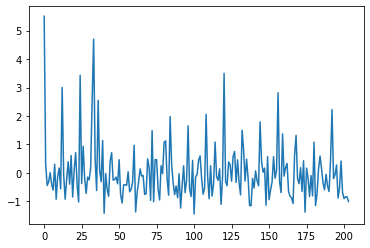

In [19]:
plt.plot(train_y[:,0]);

In [14]:
covs = []
for i in range(1, n_groups+1):
    #eta_t = pm.InverseGamma(f'eta_t_{i}', 4)
    #ell_t = pm.HalfNormal(f'ell_t_{i}', 1)
    #eta_p = pm.HalfNormal(f'eta_p_{i}', 1.5)
    #ell_p = pm.HalfNormal(f'ell_p_{i}', 0.5)
    #cov = (eta_t**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell_t)
    #      +eta_p**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell_p))
    #lengthscale_prior = gpytorch.priors.GammaPrior(3.0, 6.0)
    cov = gpytorch.kernels.RBFKernel() + gpytorch.kernels.PeriodicKernel()
    covs.append(cov)

# apply mixtures to covariances
selected_covs = []
mixed_covs = []
for i in range(groups['train']['s']):
    mixture_weights = known_mixtures[i]
    for w_ix in range(n_groups):
        w = mixture_weights[w_ix]
        if w == 1.0:
            selected_covs.append(covs[w_ix])
    mixed_cov = selected_covs[0]
    for cov in range(1,len(selected_covs)):
        mixed_cov += selected_covs[cov] # because GP(cov1 + cov2) = GP(cov1) + GP(cov2)
    mixed_covs.append(mixed_cov) 
    selected_covs = [] # clear out cov list

In [15]:
mixed_covs

[AdditiveKernel(
   (kernels): ModuleList(
     (0): RBFKernel(
       (raw_lengthscale_constraint): Positive()
     )
     (1): PeriodicKernel(
       (raw_lengthscale_constraint): Positive()
       (raw_period_length_constraint): Positive()
     )
     (2): RBFKernel(
       (raw_lengthscale_constraint): Positive()
     )
     (3): PeriodicKernel(
       (raw_lengthscale_constraint): Positive()
       (raw_period_length_constraint): Positive()
     )
     (4): RBFKernel(
       (raw_lengthscale_constraint): Positive()
     )
     (5): PeriodicKernel(
       (raw_lengthscale_constraint): Positive()
       (raw_period_length_constraint): Positive()
     )
   )
 ),
 AdditiveKernel(
   (kernels): ModuleList(
     (0): RBFKernel(
       (raw_lengthscale_constraint): Positive()
     )
     (1): PeriodicKernel(
       (raw_lengthscale_constraint): Positive()
       (raw_period_length_constraint): Positive()
     )
     (2): RBFKernel(
       (raw_lengthscale_constraint): Positive()
     )
 

In [16]:
class LinearMean(gpytorch.means.Mean):
    def __init__(self, input_size, batch_shape=torch.Size(), bias=True):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter(torch.randn(*batch_shape, input_size, 1)))
        if bias:
            self.register_parameter(name="bias", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        else:
            self.bias = None

    def forward(self, x):
        x = x.float()
        res = x.matmul(self.weights).squeeze(-1)
        if self.bias is not None:
            res = res + self.bias
        
        return res

In [17]:
class PiecewiseLinearMean(gpytorch.means.Mean):
    def __init__(self, input_size, changepoints, batch_shape=torch.Size()):
        super().__init__()
        self.changepoints = changepoints
        self.register_parameter(name="k", 
                                parameter=torch.nn.Parameter(torch.randn(*batch_shape, 
                                                                         input_size, 
                                                                         1)))
        self.register_parameter(name="m", 
                        parameter=torch.nn.Parameter(torch.randn(*batch_shape, 
                                                                 input_size,
                                                                 1)))
        self.register_parameter(name="b", 
                        parameter=torch.nn.Parameter(torch.randn(*batch_shape, 
                                                                 len(changepoints))))

    def forward(self, x):
        x = x.float()
        A = (0.5 * (1.0 + torch.sgn(torch.tile(x.reshape((-1,1)), (1,4)) - self.changepoints))).float()
        
        res = ((self.k + torch.matmul(A, self.b.reshape((-1,1))))*x 
               + (self.m + torch.matmul(A, (-torch.from_numpy(changepoints).float() * self.b))).reshape(-1,1))

        return res.reshape((-1,))

In [18]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, cov, changepoints):
        super().__init__(train_x, train_y, likelihood)
        self.changepoints = changepoints
        self.mean_module = PiecewiseLinearMean(train_x.size(-1), self.changepoints)
        self.covar_module = cov
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

n_changepoints = 4
changepoints = np.linspace(0, groups['train']['n'], n_changepoints+2)[1:-1]

model_list = []
likelihood_list = []
for i in range(groups['train']['s']):
    likelihood_list.append(gpytorch.likelihoods.GaussianLikelihood())
    model_list.append(ExactGPModel(train_x, train_y[:,i], likelihood_list[i], mixed_covs[i], changepoints))

    
model = gpytorch.models.IndependentModelList(*model_list)
likelihood = gpytorch.likelihoods.LikelihoodList(*likelihood_list)

In [19]:
from gpytorch.mlls import SumMarginalLogLikelihood

mll = SumMarginalLogLikelihood(likelihood, model)

In [20]:
model

IndependentModelList(
  (models): ModuleList(
    (0): ExactGPModel(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): PiecewiseLinearMean()
      (covar_module): AdditiveKernel(
        (kernels): ModuleList(
          (0): RBFKernel(
            (raw_lengthscale_constraint): Positive()
          )
          (1): PeriodicKernel(
            (raw_lengthscale_constraint): Positive()
            (raw_period_length_constraint): Positive()
          )
          (2): RBFKernel(
            (raw_lengthscale_constraint): Positive()
          )
          (3): PeriodicKernel(
            (raw_lengthscale_constraint): Positive()
            (raw_period_length_constraint): Positive()
          )
          (4): RBFKernel(
            (raw_lengthscale_constraint): Positive()
          )
          (5): PeriodicKernel(
            (raw_lengthscale_constraint): Positive()
  

In [21]:
# this is for running the notebook in our testing framework

training_iterations = 500

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/500 - Loss: 32.062
Iter 2/500 - Loss: 21.795
Iter 3/500 - Loss: 16.172
Iter 4/500 - Loss: 11.973
Iter 5/500 - Loss: 9.189
Iter 6/500 - Loss: 7.367
Iter 7/500 - Loss: 6.057
Iter 8/500 - Loss: 5.149
Iter 9/500 - Loss: 4.476
Iter 10/500 - Loss: 3.831
Iter 11/500 - Loss: 3.090
Iter 12/500 - Loss: 2.750
Iter 13/500 - Loss: 2.768
Iter 14/500 - Loss: 2.973
Iter 15/500 - Loss: 2.828
Iter 16/500 - Loss: 2.982
Iter 17/500 - Loss: 3.129
Iter 18/500 - Loss: 3.164
Iter 19/500 - Loss: 3.098
Iter 20/500 - Loss: 3.012
Iter 21/500 - Loss: 2.851
Iter 22/500 - Loss: 2.664
Iter 23/500 - Loss: 2.491
Iter 24/500 - Loss: 2.376
Iter 25/500 - Loss: 2.279
Iter 26/500 - Loss: 2.187
Iter 27/500 - Loss: 2.122
Iter 28/500 - Loss: 2.071
Iter 29/500 - Loss: 2.023
Iter 30/500 - Loss: 1.972
Iter 31/500 - Loss: 1.919
Iter 32/500 - Loss: 1.869
Iter 33/500 - Loss: 1.826
Iter 34/500 - Loss: 1.791
Iter 35/500 - Loss: 1.762
Iter 36/500 - Loss: 1.738
Iter 37/500 - Loss: 1.717
Iter 38/500 - Loss: 1.697
Iter 39/500 - Los

Iter 309/500 - Loss: 0.701
Iter 310/500 - Loss: 0.701
Iter 311/500 - Loss: 0.700
Iter 312/500 - Loss: 0.700
Iter 313/500 - Loss: 0.699
Iter 314/500 - Loss: 0.698
Iter 315/500 - Loss: 0.698
Iter 316/500 - Loss: 0.697
Iter 317/500 - Loss: 0.697
Iter 318/500 - Loss: 0.696
Iter 319/500 - Loss: 0.696
Iter 320/500 - Loss: 0.695
Iter 321/500 - Loss: 0.694
Iter 322/500 - Loss: 0.694
Iter 323/500 - Loss: 0.693
Iter 324/500 - Loss: 0.693
Iter 325/500 - Loss: 0.692
Iter 326/500 - Loss: 0.692
Iter 327/500 - Loss: 0.691
Iter 328/500 - Loss: 0.690
Iter 329/500 - Loss: 0.690
Iter 330/500 - Loss: 0.689
Iter 331/500 - Loss: 0.689
Iter 332/500 - Loss: 0.688
Iter 333/500 - Loss: 0.688
Iter 334/500 - Loss: 0.687
Iter 335/500 - Loss: 0.686
Iter 336/500 - Loss: 0.686
Iter 337/500 - Loss: 0.685
Iter 338/500 - Loss: 0.685
Iter 339/500 - Loss: 0.684
Iter 340/500 - Loss: 0.684
Iter 341/500 - Loss: 0.683
Iter 342/500 - Loss: 0.682
Iter 343/500 - Loss: 0.682
Iter 344/500 - Loss: 0.681
Iter 345/500 - Loss: 0.681
I

In [22]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions (use the same test points)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.arange(groups['predict']['n']).type(torch.DoubleTensor)
    # This contains predictions for both outcomes as a list
    #predictions = likelihood(*model(test_x, test_x))
    predictions = likelihood(*model(*[test_x for i in range(groups['predict']['s'])]))

In [23]:
i = 0
mean = np.zeros((1, groups['predict']['n'], groups['predict']['s']))
lower = np.zeros((1, groups['predict']['n'], groups['predict']['s']))
upper = np.zeros((1, groups['predict']['n'], groups['predict']['s']))
for pred in predictions:
    mean[:,:,i] = pred.mean
    lower[:,:,i], upper[:,:,i] = pred.confidence_region()
    i+=1

mean = ((mean*dt.std_data) + dt.mu_data)
lower = ((lower*dt.std_data) + dt.mu_data)
upper = ((upper*dt.std_data) + dt.mu_data)
groups = dt.inv_transf_train()

pred = groups['predict']['data'].reshape((groups['predict']['s'], -1)).T

In [24]:
res = calculate_metrics(mean, groups)
metrics_to_table(res)
with open(f'results_gp_cov_{dataset}.pickle', 'wb') as handle:
    pickle.dump(res, handle, pickle.HIGHEST_PROTOCOL)

,bottom,total,state,gender,legal,all
mase,2.739,0.17,1.975,0.409,3.218,2.453
rmse,148.993,256.899,309.317,197.191,1841.075,160.983


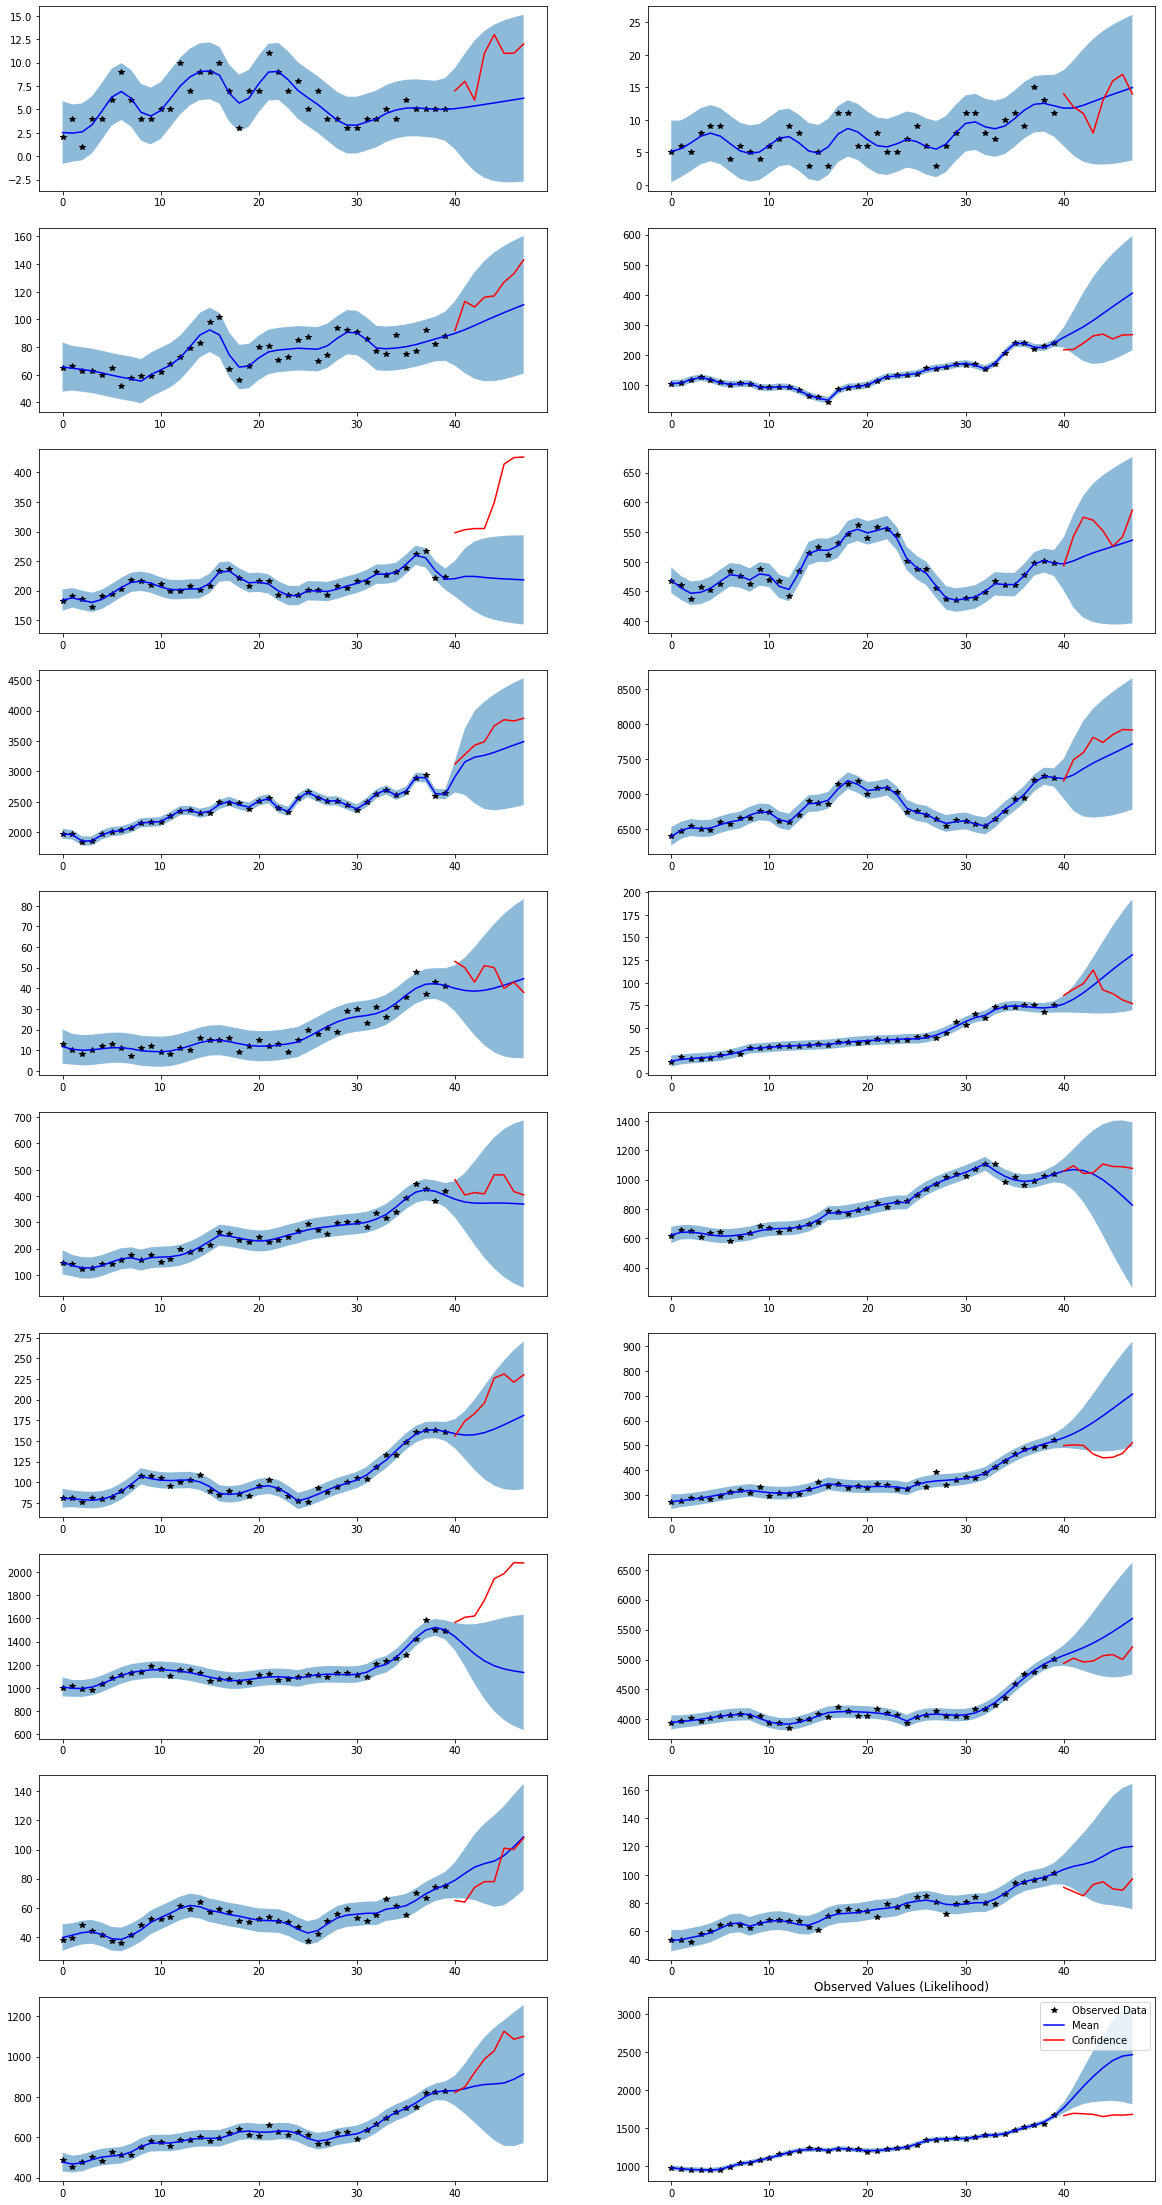

In [25]:
# Initialize plots
f, ax = plt.subplots(10, 2, figsize=(20, 40))
ax = ax.ravel()
for i in range(20):
    # Plot training data as black stars
    ax[i].plot(train_x, groups['train']['data'][:,i], 'k*')
    # Predictive mean as blue line
    ax[i].plot(test_x.numpy(), mean[0,:,i], 'b')
    # Shade in confidence
    ax[i].fill_between(test_x.numpy(), lower[0,:,i], upper[0,:,i], alpha=0.5)
    ax[i].plot(test_x[groups['train']['n']:].numpy(), pred[groups['train']['n']:,i], 'r')
    
    plt.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.title('Observed Values (Likelihood)')

None

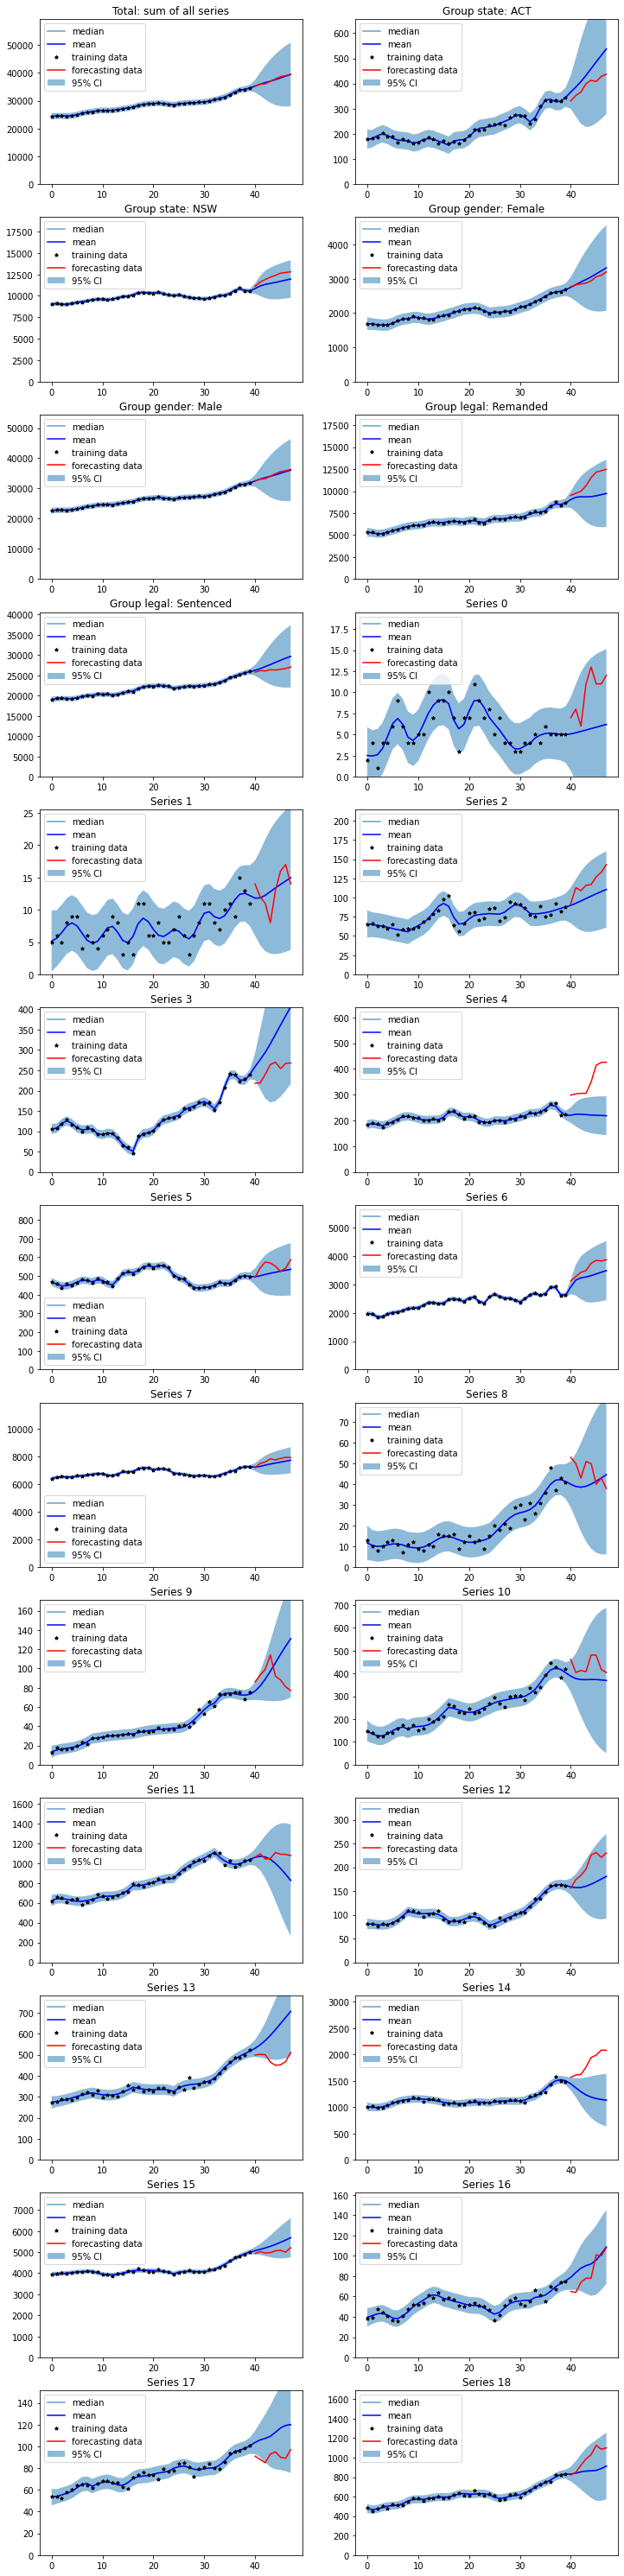

In [54]:
visualize_predict(groups, mean, lower, upper, 20)

In [27]:
import numpy as np
import tabulate
from sklearn.metrics import mean_squared_error
from IPython.display import HTML, display
import pandas as pd


def mase(n,seas,h,y,f):
    return np.mean(((n-seas)/h
            * (np.sum(np.abs(y[n:n+h,:] - f), axis=0)
               / np.sum(np.abs(y[seas:n, :] - y[:n-seas, :]), axis=0))))


def calculate_metrics(pred_samples,
                      groups):

    pred_s0 = pred_samples.shape[0]
    pred_s1 = pred_samples.shape[1]
    pred_s2 = pred_samples.shape[2]

    pred_samples = pred_samples.reshape(pred_s0, pred_s1*pred_s2, order='F')

    seasonality = groups['seasonality']
    h = groups['h']
    
    n = groups['predict']['n']
    s = groups['predict']['s']
    y_f = groups['predict']['data'].reshape(s, n).T

    y_all_g = {}
    f_all_g = {}
    
    mase_ = {}
    rmse_ = {}
    
    # Bottom
    y_all_g['bottom'] = y_f
    f_all_g['bottom'] = np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:]
    
    mase_['bottom'] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=y_f, 
                                     f=np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:]),3)
    rmse_['bottom'] = np.round(mean_squared_error(y_f[n-h:n,:], np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], squared=False), 3)

    # Total
    y_all_g['total'] = np.sum(y_f, axis=1).reshape(-1,1)
    f_all_g['total'] = np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], axis=1).reshape(-1,1)
    
    mase_['total'] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=np.sum(y_f, axis=1).reshape(-1,1), 
                                     f=np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], axis=1).reshape(-1,1))
                            ,3)
    rmse_['total'] = np.round(mean_squared_error(np.sum(y_f, axis=1).reshape(-1,1)[n-h:n,:], 
                                             np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:],axis=1).reshape(-1,1), 
                                             squared=False), 3)

    # Groups
    idx_dict_new = {}
    for group in list(groups['predict']['groups_names'].keys()):
        y_g = np.zeros((groups['predict']['n'], groups['predict']['groups_names'][group].shape[0]))
        f_g = np.zeros((h, groups['predict']['groups_names'][group].shape[0]))

        for idx, name in enumerate(groups['predict']['groups_names'][group]):               

            g_n = groups['predict']['groups_n'][group]

            idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)

            y_g[:,idx] = np.sum(idx_dict_new[name]*y_f, axis=1)
            f_g[:,idx] = np.sum(idx_dict_new[name]*np.mean(pred_samples, axis=0).reshape(s, n).T, axis=1)[n-h:n]

        y_all_g[group] = np.sum(y_g, axis=1).reshape(-1,1)
        f_all_g[group] = np.sum(f_g, axis=1).reshape(-1,1)

        mase_[group] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=y_g, 
                                     f=f_g)
                                ,3)

        rmse_[group] = np.round(mean_squared_error(y_g[n-h:n,:], f_g, squared=False), 3)

    # All
    y_all = np.concatenate([y_all_g[x] for x in y_all_g], 1)
    f_all = np.concatenate([f_all_g[x] for x in f_all_g], 1)

    mase_['all'] = np.round(mase(n=n-h, 
                         seas=seasonality, 
                         h=h, 
                         y=y_all, 
                         f=f_all),3)
    rmse_['all'] = np.round(mean_squared_error(y_all[n-h:n,:], f_all, squared=False), 3)
    
    results = {}
    results['mase'] = mase_
    results['rmse'] = rmse_
    return results


def metrics_to_table(metrics):
    metrics_l = []
    metrics_v = []
    for metric_name in metrics:
        metrics_list=[]
        metrics_values=[]
        metrics_list.append('')
        metrics_values.append(metric_name)
        for key, metric in metrics[metric_name].items():
            metrics_list.append(key)
            metrics_values.append(metric)
        metrics_v.append(metrics_values)
    metrics_l.append(metrics_list)
    metrics_l.extend(metrics_v)
    table = metrics_l
    display(HTML(tabulate.tabulate(table, tablefmt='html')))

In [53]:
def visualize_predict(groups, pred_samples_predict, lower, upper, n_bottom_series_to_show, levels=[0,1,2]):
    """
    Parameters
    ----------
    levels: list
                0 -> total, 1 -> groups, 2 -> bottom
                Default to [0,1,2]
    """
    n_series_to_show = n_bottom_series_to_show
    if 0 in levels:
        n_series_to_show += 1 
    if 1 in levels:
        for _,k in groups['predict']['groups_n'].items():
            n_series_to_show += 2 # only show two series of each group aggregate
            
    fig, ax = plt.subplots(int(n_series_to_show/2), 2, figsize=(12,n_series_to_show*2))
    ax = np.ravel(ax)
    n = groups['train']['n']
    n_new = groups['predict']['n']
    j = 0
    if 0 in levels:
        y_f = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T
        y_all_g = np.sum(y_f, axis=1).reshape(-1,1)

        ax[j].fill_between(np.arange(n_new), 
                        np.sum(lower[0,:,:], axis=1),
                        np.sum(upper[0,:,:], axis=1),
                        label='95% CI', alpha=0.5)
        ax[j].plot(np.arange(n_new), 
                np.median(np.sum(pred_samples_predict, axis=2).T, axis=1),
                color='tab:blue', alpha=0.7, label='median')
        ax[j].plot(np.arange(n_new), 
                np.mean(np.sum(pred_samples_predict, axis=2).T, axis=1),
                color='b', label='mean')
        ax[j].set_ylim(0,max(np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)*1.5))
        ax[j].plot(np.sum(groups['train']['full_data'], axis=1), 
                'k*',markersize=4, label='training data')
        ax[j].plot(np.arange(n, n_new),
                np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)[n:],
                color='r', label='forecasting data')
        ax[j].legend()
        ax[j].set_title('Total: sum of all series')
        j+=1
    if 1 in levels:
        idx_dict_new = {}
        y_all_g = {}
        f_all_g = {}
        lower_all_g = {}
        upper_all_g = {}
        y_f = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T
        for id_group, group in enumerate(list(groups['predict']['groups_names'].keys())):
            y_g = np.zeros((groups['predict']['n'], 1))
            f_g = np.zeros((groups['predict']['groups_names'][group].shape[0]))

            y_all_g[group] = {}
            f_all_g[group] = {}
            
            lower_all_g[group] = {}
            upper_all_g[group] = {}

            for idx, name in enumerate(groups['predict']['groups_names'][group]):               
                # Only show 2 plots of each group -> change this is to show more
                if idx < 2:
                    g_n = groups['predict']['groups_n'][group]

                    idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)

                    y_g = np.sum(idx_dict_new[name].reshape(1,-1)*y_f, axis=1)
                    f_g = np.sum(idx_dict_new[name].reshape(1,-1)*pred_samples_predict, axis=(2))
                    
                    lower_g = np.sum(idx_dict_new[name].reshape(1,-1)*lower, axis=(2))
                    upper_g = np.sum(idx_dict_new[name].reshape(1,-1)*upper, axis=(2))

                    y_all_g[group][name] = y_g
                    f_all_g[group][name] = f_g
                    lower_all_g[group][name] = lower_g
                    upper_all_g[group][name] = upper_g

                    ax[j].fill_between(np.arange(groups['predict']['n']), 
                                    lower_all_g[group][name][0],
                                    upper_all_g[group][name][0],
                                    label='95% CI', alpha=0.5)
                    ax[j].plot(np.arange(groups['predict']['n']), 
                            np.median(f_all_g[group][name], axis=0),
                            color='tab:blue', alpha=0.7, label='median')
                    ax[j].plot(np.arange(groups['predict']['n']), 
                            np.mean(f_all_g[group][name], axis=0),
                            color='b', label='mean')
                    ax[j].set_ylim(0,max(y_all_g[group][name])*1.5)
                    ax[j].plot(y_all_g[group][name][:groups['train']['n']], 
                            'k*', markersize=4, label='training data')
                    ax[j].plot(np.arange(groups['train']['n'], groups['predict']['n']),
                            y_all_g[group][name][groups['train']['n']:],
                            color='r', label='forecasting data')
                    ax[j].legend()
                    ax[j].set_title(f'Group {group}: {name}')

                    j+=1
    if 2 in levels:
        for i in range(n_bottom_series_to_show-1):
            ax[j].fill_between(np.arange(n_new), 
                            lower[0,:,i],
                            upper[0,:,i],
                        label='95% CI', alpha=0.5)
            ax[j].plot(np.arange(n_new), np.median(pred_samples_predict[:,:,i], axis=0), color='tab:blue', alpha=0.7, label='median')
            ax[j].plot(np.arange(n_new), np.mean(pred_samples_predict[:,:,i], axis=0), color='b', label='mean')
            ax[j].set_ylim(0,max(groups['predict']['data'][i*n_new:i*n_new+n_new])*1.5)
            ax[j].plot(groups['train']['full_data'][:,i], 'k*', markersize=4, label='training data')
            ax[j].plot(np.arange(n, n_new), groups['predict']['data'][i*n_new+n:i*n_new+n_new], color='r', label='forecasting data')
            ax[j].legend()
            ax[j].set_title(f'Series {i}',)
            j+=1
